<a href="https://colab.research.google.com/github/azzindani/02_Machine_Learning/blob/main/Multiple_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version 20240815

## 00 Importing Modules & Mounting Drive

In [1]:
!pip install ydata-profiling

import pathlib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import sklearn
import pickle
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb

from scipy import stats as sm
from IPython.display import Image
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, accuracy_score, average_precision_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from ydata_profiling import ProfileReport
from tabulate import tabulate
from time import sleep

%matplotlib inline

In [2]:
'''from google.colab import drive
drive.mount('/content/drive') #'''

"from google.colab import drive\ndrive.mount('/content/drive') #"

In [3]:
'''MAIN_PATH = str(pathlib.Path().resolve())
WORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'
SOURCE_PATH = WORK_PATH + '/00_Data_Source'
CACHE_PATH = WORK_PATH + '/00_Cache_Data' #'''

"MAIN_PATH = str(pathlib.Path().resolve())\nWORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'\nSOURCE_PATH = WORK_PATH + '/00_Data_Source'\nCACHE_PATH = WORK_PATH + '/00_Cache_Data' #"

## 01 Choosing & Importing Dataset

### 01.00 Importing Data from Zipfile

In [4]:
'''filename = 'Mental_Health_Survey.zip' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall() #'''

"filename = 'Mental_Health_Survey.zip' # replace this\n\nurl = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename\nhttp_response = urlopen(url)\nzipfile = ZipFile(BytesIO(http_response.read()))\nzipfile.extractall() #"

In [5]:
os.listdir()

['.config',
 'Mental Health Dataset.csv',
 'city_temperature.csv',
 'Combined Data.csv',
 'sample_data']

In [6]:
'''df = pd.read_csv(os.listdir()[1], encoding = 'ISO-8859-1')#, sep = ';')
df.shape #'''

"df = pd.read_csv(os.listdir()[1], encoding = 'ISO-8859-1')#, sep = ';')\ndf.shape #"

### 01.01 Importing Main Data

In [7]:
filename = 'Multiple_Disease_Prediction.csv' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
df = pd.read_csv(url, encoding = 'ISO-8859-1')#, sep = ';')
df.shape #'''

(2351, 25)

In [8]:
df.nunique()

,0
Glucose,65
Cholesterol,65
Hemoglobin,65
Platelets,65
White Blood Cells,65
Red Blood Cells,65
Hematocrit,65
Mean Corpuscular Volume,65
Mean Corpuscular Hemoglobin,65
Mean Corpuscular Hemoglobin Concentration,65


In [9]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [11]:
for column in df.columns:
  if df[column].dtypes == 'object':
    print(column)
    print('-' * 100)
    print(df[column].unique())
    print('=' * 100)

Disease
----------------------------------------------------------------------------------------------------
['Healthy' 'Diabetes' 'Thalasse' 'Anemia' 'Thromboc']


### 01.02 Importing Geo Data

In [12]:
'''geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this

gdf = gpd.read_file(geo_path)
gdf.head(2) #'''

"geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this\n\ngdf = gpd.read_file(geo_path)\ngdf.head(2) #"

In [13]:
'''gdf = gdf.rename(columns = {'name' : 'State'})
gdf = gdf[['State', 'geometry']]
gdf.head(2) #'''

"gdf = gdf.rename(columns = {'name' : 'State'})\ngdf = gdf[['State', 'geometry']]\ngdf.head(2) #"

### 01.03 Importing Additional Data (for enrichment)

### 01.04 Dataframe Back Up

In [14]:
df_bu = df.copy()

## 02 Data Structuring

### 02.01 Selecting & Dropping Variables

In [15]:
column_list = [] # fill this

df = df.drop(column_list, axis = 1)
df.head(2) #'''

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


### 02.02 Cleaning Text Object

#### 02.02.01 Convert Header to Proper Text

In [16]:
'''for x in df.columns:
  y = x.title()
  df = df.rename(columns = {x : y}) #'''

'for x in df.columns:\n  y = x.title()\n  df = df.rename(columns = {x : y}) #'

#### 02.02.02 Strip Abnormal Spaces

In [17]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    try:
      df[x] = df[x].str.strip()
    except:
      pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    try:\n      df[x] = df[x].str.strip()\n    except:\n      pass #"

#### 02.02.03 Convert Object Content to Proper Text

In [18]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    for a in df[x].unique():
      b = a.title()
      df[x] = df[x].replace(a, b)
  else:
    pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    for a in df[x].unique():\n      b = a.title()\n      df[x] = df[x].replace(a, b)\n  else:\n    pass #"

### 02.03 Coverting Data

#### 02.03.01 Convert to date

In [19]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [20]:
column_list = ['Activity Period Start Date'] # fill this

for x in column_list:
  try:
    df[x] = pd.to_datetime(df[x])
  except:
    pass #'''

#### 02.03.02 Convert to integer

In [21]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('int') #'''

#### 02.03.03 Convert to Object (if necessary)

In [22]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('str') #'''

#### 02.03.04 Replace 0 to Nan (if necessary)

In [23]:
#df = df.replace(0, np.nan)

#### 02.03.05 Filling 0 to Nan

In [24]:
'''for column in df.columns:
  if df[column].dtype == 'float64' or df[column].dtype == 'int64':
    df[column] = df[column].fillna(0)
    print(column)
  else:
    pass #'''

"for column in df.columns:\n  if df[column].dtype == 'float64' or df[column].dtype == 'int64':\n    df[column] = df[column].fillna(0)\n    print(column)\n  else:\n    pass #"

#### 02.03.06 Dropping Nan

In [25]:
df = df.dropna()

## 03 Data Cleaning

### 03.01 Replacing Variable Component

In [26]:
'''value_dict = {} # fill this

column_name = ''

df[column_name] = df[column_name].replace(value_dict) #'''

"value_dict = {} # fill this\n\ncolumn_name = ''\n\ndf[column_name] = df[column_name].replace(value_dict) #"

### 03.02 Add New Variable

#### 03.02.01 Add by Math Calculation

In [27]:
'''new_var = '' # fill this
obj_var1 = '' # fill this
obj_var2 = '' # fill this

df[new_var] = df[obj_var1] * df [obj_var2] #'''

"new_var = '' # fill this\nobj_var1 = '' # fill this\nobj_var2 = '' # fill this\n\ndf[new_var] = df[obj_var1] * df [obj_var2] #"

#### 03.02.02 Add by Replacing "Other"

In [28]:
'''column_name = '' # fill this

df[column_name].value_counts() #'''

"column_name = '' # fill this\n\ndf[column_name].value_counts() #"

In [29]:
'''value_thres = 1300

replace_list = []

df_dict = df[column_name].value_counts().to_dict()
for i in df_dict:
  if df_dict[i] < value_thres:
    replace_list.append(i)

replace_list #'''

'value_thres = 1300\n\nreplace_list = []\n\ndf_dict = df[column_name].value_counts().to_dict()\nfor i in df_dict:\n  if df_dict[i] < value_thres:\n    replace_list.append(i)\n\nreplace_list #'

In [30]:
'''df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #'''

"df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #"

### 03.03 Inaccuracies

In [31]:
column_list = [] # fill this

for x in column_list:
  try:
    df[x] = df[x].replace('0', np.nan)
    df = df.dropna()
  except:
    pass

### 03.04 Handling

##### Data Distribution Check (Before)

In [32]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [34]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [35]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

#### 03.04.01 Using IQR (Inter Quantile Range)

In [36]:
def iqr_thres(dataframe, column, th1 = 0.25, th3 = 0.75):
  quartile1 = dataframe[column].quantile(th1)
  quartile3 = dataframe[column].quantile(th3)
  iqr = quartile3 - quartile1
  upper_limit = quartile3 + 1.5 * iqr
  lower_limit = quartile1 - 1.5 * iqr

  return lower_limit, upper_limit

In [37]:
def check_outliers_iqr(dataframe, column):
  lower_limit, upper_limit = iqr_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [38]:
def replace_iqr(dataframe, columns, th1 = 0.25, th3 = 0.75, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_iqr(dataframe, column)
        count = None
        lower_limit, upper_limit = iqr_thres(dataframe, column, th1, th3)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_iqr(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit ])

  table = tabulate(data, headers = ['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using IQR')
  print(table)

In [39]:
column_list = [] # fill this

replace_iqr(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using IQR
=======================  ==========  =======  ========  =============  =============
Outliers (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
=======================  ==========  =======  ========  =============  =============
=======================  ==========  =======  ========  =============  =============


#### 03.04.02 Using Standard Deviation

In [40]:
def std_thres(dataframe, column):
  upper_limit = dataframe[column].mean() + 3 * dataframe[column].std()
  lower_limit = dataframe[column].mean() - 3 * dataframe[column].std()

  return lower_limit, upper_limit

In [41]:
def check_outliers_std(dataframe, column):
  lower_limit, upper_limit = std_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [42]:
def replace_std(dataframe, columns, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_std(dataframe, column)
        count = None
        lower_limit, upper_limit = std_thres(dataframe, column)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_std(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit])

  table = tabulate(data, headers = ['Outlier (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using 3 Standard Deviation')
  print(table)

In [43]:
column_list = [] # fill this

replace_std(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========  =============  =============
Outlier (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
======================  ==========  =======  ========  =============  =============
======================  ==========  =======  ========  =============  =============


### 03.05 Handling Missing / Zeros / Null
##### Filling missing value (numerical only) is better using median than mean or mode

#### 03.05.01 Detecting Zero Value

In [44]:
zero_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'int64' or df[x].dtypes == 'float64':
    if (df[x] == 0).sum() != 0:
      print(x, ':', str((df[x] == 0).sum()))
      zero_columns.append(x)

zero_columns #'''

[]

#### 03.05.02 Detecting Nan / Non Available Value

In [45]:
nan_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'object':
    if (df[x] == np.nan).sum() or (df[x] == '-').sum() != 0:
      print(x, ':', str((df[x] == np.nan).sum()))
      nan_columns.append(x)

nan_columns #'''

[]

#### 03.05.03 Replacing Zero with Mean (for numerical value if median value == 0), if necessary

In [46]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mean()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mean()) #'

#### 03.05.04 Replacing Zero with Median (for numerical value if median value != 0), if necessary

In [47]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].median()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].median()) #'

#### 03.05.05 Replacing Zero with Mode (for categorical / object value), if necessary

In [48]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mode()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mode()) #'

### 03.06 Handling Incomplete Data

### 03.07 Handling Data Biases

### 03.08 Handling Duplicates

In [49]:
#df = df.drop_duplicates()

##### Data Distribution Check (After)

In [50]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [51]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

## 04 Enriching Data
#### take other dataset, inside or outside from related dataset / business

In [52]:
'''location = 'Country' # replace this

a = df[location].unique()
b = gdf[location].unique()

for i in a:
  if i not in b:
    print(i)

print(50 * '=')

for i in b:
  if i not in a:
    print(i) #'''

"location = 'Country' # replace this\n\na = df[location].unique()\nb = gdf[location].unique()\n\nfor i in a:\n  if i not in b:\n    print(i)\n\nprint(50 * '=')\n\nfor i in b:\n  if i not in a:\n    print(i) #"

In [53]:
value_dict = {}

try:
  df[location] = df[location].replace(value_dict)
except:
  pass #'''

## 05 Data Validation
#### Verifying consistency, quality, and security of data

## 06 Exploration Data Analysis (Univariate)

In [54]:
'''data_profile = ProfileReport(
  df,
  correlations = {
    'pearson' : {'calculate' : True},
    'spearman' : {'calculate' : True},
    'kendall' : {'calculate' : True},
    'phi_k' : {'calculate' : True},
    'cramers': {'calculate' : True},
  },
)

data_profile #'''

"data_profile = ProfileReport(\n  df,\n  correlations = {\n    'pearson' : {'calculate' : True},\n    'spearman' : {'calculate' : True},\n    'kendall' : {'calculate' : True},\n    'phi_k' : {'calculate' : True},\n    'cramers': {'calculate' : True},\n  },\n)\n\ndata_profile #"

## 07 Select Variable X & Y | Splitting Data

#### 07.01 Data Balancing

In [55]:
'''# Check Before Data Balancing
y_var = 'converted'

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in df[y_var].value_counts()]
labels = list(df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check Before Data Balancing\ny_var = 'converted'\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in df[y_var].value_counts()]\nlabels = list(df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

In [56]:
'''n = 15000
append_data = []

for i in df[y_var].unique():
  df_x = df[df[y_var] == i][:n]
  append_data.append(df_x)

append_df = pd.concat(append_data)
append_df.shape #'''

'n = 15000\nappend_data = []\n\nfor i in df[y_var].unique():\n  df_x = df[df[y_var] == i][:n]\n  append_data.append(df_x)\n\nappend_df = pd.concat(append_data)\nappend_df.shape #'

In [57]:
'''# Check After Data Balancing
df = append_df

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in append_df[y_var].value_counts()]
labels = list(append_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check After Data Balancing\ndf = append_df\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in append_df[y_var].value_counts()]\nlabels = list(append_df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

### 07.02 Label Encoding / One Hot Encoding

In [58]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [60]:
columns = ['Disease']

for column in columns:
  df[column] = df[column].astype('str')
  print(df[column].unique())

['Healthy' 'Diabetes' 'Thalasse' 'Anemia' 'Thromboc']


In [61]:
label_encoders = {}

for column in columns:
  le = LabelEncoder()
  df[column] = le.fit_transform(df[column])
  label_encoders[column] = le

for column in columns:
  labels = label_encoders[column].classes_
  print(column)
  print('-' * 50)
  for i in range(len(labels)):
    print(str(i), ':', labels[i])
  print('=' * 50)

Disease
--------------------------------------------------
0 : Anemia
1 : Diabetes
2 : Healthy
3 : Thalasse
4 : Thromboc


### 07.03 Define X & Y variables

In [62]:
df.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,2
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,1


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    2351 non-null   float64
 1   Cholesterol                                2351 non-null   float64
 2   Hemoglobin                                 2351 non-null   float64
 3   Platelets                                  2351 non-null   float64
 4   White Blood Cells                          2351 non-null   float64
 5   Red Blood Cells                            2351 non-null   float64
 6   Hematocrit                                 2351 non-null   float64
 7   Mean Corpuscular Volume                    2351 non-null   float64
 8   Mean Corpuscular Hemoglobin                2351 non-null   float64
 9   Mean Corpuscular Hemoglobin Concentration  2351 non-null   float64
 10  Insulin                 

In [64]:
#x_var = []
x_var = df.columns[:24]
y_var = ['Disease']

x = df[x_var]
y = df[y_var]

sel_var = y_var + x_var
#df = df[sel_var]
x.head(2)

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,Triglycerides,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.653472,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.477742,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166


### 07.04 Split Data

In [65]:
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print('x_train shape :', x_train.shape)
print('x_test shape :', x_test.shape)
print('=' * 50)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

x_train shape : (1880, 24)
x_test shape : (471, 24)
y_train shape : (1880, 1)
y_test shape : (471, 1)


## 08 Building Machine Learning Model
https://www.geeksforgeeks.org/types-of-machine-learning/

### 08.01 Supervised Machine Learning
meaning = y variable already available from dataset / “Labelled Dataset”



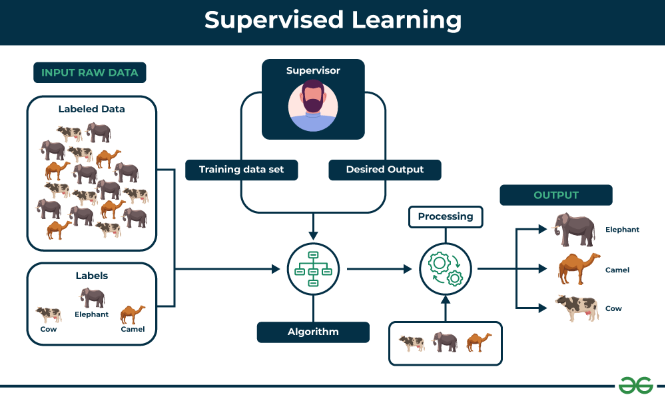

#### 08.01.01 Classification
predicting categorical target variables, which represent discrete classes or labels

##### 08.01.01.01 Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
def lr(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'Logistic Regression Model'
    model = LogisticRegression()
    train = model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    training_score = model.score(x_train, y_train)
    testing_score = model.score(x_test, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    #print('Regression Coefficient :', str(train.coef_))
    #print('Regression Interception :', str(train.intercept_))
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model
Training Score :  100.0 %
Testing Score :  100.0 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        20

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471

Confusion Matrix


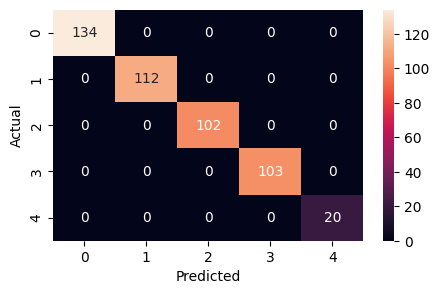

In [68]:
lr(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.02 Support Vector Machine

In [69]:
from sklearn.svm import SVC

In [70]:
def svm(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'Support Vector Machine Model'
    model = SVC()
    train = model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    training_score = model.score(x_train, y_train)
    testing_score = model.score(x_test, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Machine Model
Training Score :  100.0 %
Testing Score :  100.0 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        20

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471

Confusion Matrix


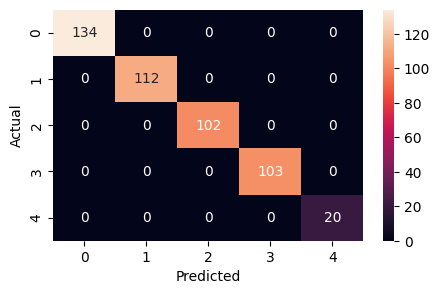

In [71]:
svm(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.03 Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
def rf(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'Random Forest Model'
    model = RandomForestClassifier()
    train = model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    training_score = model.score(x_train, y_train)
    testing_score = model.score(x_test, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Model
Training Score :  100.0 %
Testing Score :  100.0 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        20

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471

Confusion Matrix


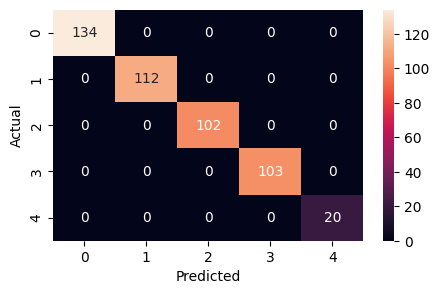

In [74]:
rf(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.04 Decision Tree Classifier

In [75]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [76]:
def dtc(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'Decision Tree Classifier Model'
    model = DecisionTreeClassifier()
    train = model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    training_score = model.score(x_train, y_train)
    testing_score = model.score(x_test, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

Decision Tree Classifier Model
Training Score :  100.0 %
Testing Score :  100.0 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        20

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471

Confusion Matrix


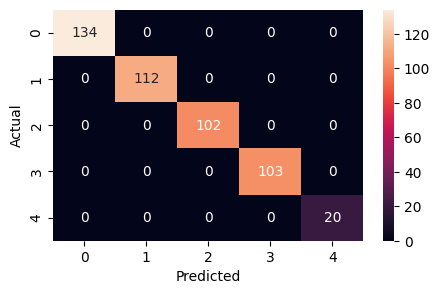

In [77]:
dtc(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.05 K-Nearest Neighbors (KNN)

In [78]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
def knn(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'K-Nearest Neighbors Model'
    model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    sc = StandardScaler()
    x_train_sc = sc.fit_transform(x_train)
    x_test_sc = sc.transform(x_test)

    train = model.fit(x_train_sc, y_train)
    y_predicted = model.predict(x_test_sc)
    training_score = model.score(x_train_sc, y_train)
    testing_score = model.score(x_test_sc, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbors Model
Training Score :  100.0 %
Testing Score :  100.0 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       103
           4       1.00      1.00      1.00        20

    accuracy                           1.00       471
   macro avg       1.00      1.00      1.00       471
weighted avg       1.00      1.00      1.00       471

Confusion Matrix


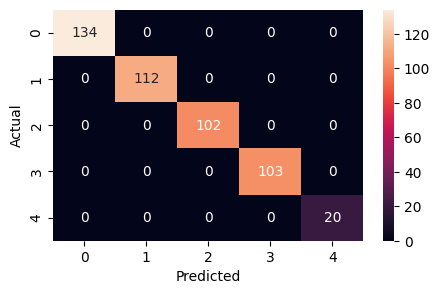

In [80]:
knn(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.06 Naive Bayes

In [81]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [82]:
def nb(x_train, y_train, x_test, y_test, save = False, matrix = False, unmatch = False):
  try:
    title = 'Naive Bayes Model'
    model = GaussianNB()
    train = model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    training_score = model.score(x_train, y_train)
    testing_score = model.score(x_test, y_test)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Testing Score : ', str(round(testing_score * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes Model
Training Score :  93.24 %
Testing Score :  90.87 %
Classification Report
               precision    recall  f1-score   support

           0       1.00      0.87      0.93       134
           1       1.00      0.90      0.95       112
           2       0.72      0.95      0.82       102
           3       0.95      0.90      0.93       103
           4       1.00      1.00      1.00        20

    accuracy                           0.91       471
   macro avg       0.93      0.93      0.92       471
weighted avg       0.93      0.91      0.91       471

Confusion Matrix


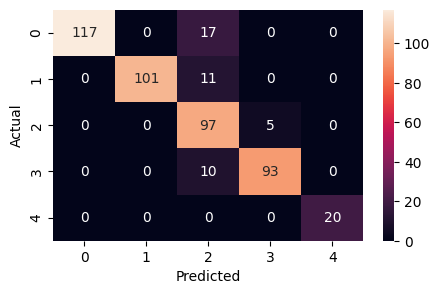

In [83]:
nb(x_train, y_train, x_test, y_test, save = False, matrix = True, unmatch = False)

##### 08.01.01.07 K Fold Cross Validation

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits = 3)
folds = StratifiedKFold(n_splits = 3)

In [85]:
def get_score(model, x_train, x_test, y_train, y_test):
  model.fit(x_train, y_train)
  score = model.score(x_test, y_test)
  rounded = str(round(score * 100, 2)) + '%'
  return rounded

In [86]:
scores_lr = []
scores_svm = []
scores_rf = []
scores_dtc = []
scores_knn = []
scores_nb = []

try:
  for train_index, test_index in kf.split(x):
    scores_lr.append(get_score(LogisticRegression(), x_train, x_test, y_train, y_test))
    scores_svm.append(get_score(SVC(), x_train, x_test, y_train, y_test))
    scores_rf.append(get_score(RandomForestClassifier(), x_train, x_test, y_train, y_test))
    scores_dtc.append(get_score(DecisionTreeClassifier(), x_train, x_test, y_train, y_test))
    scores_knn.append(get_score(KNeighborsClassifier(), x_train, x_test, y_train, y_test))
    scores_nb.append(get_score(GaussianNB(), x_train, x_test, y_train, y_test))
except:
  pass

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

In [87]:
try:
  print('Logistic Regression Score :', str(scores_lr))
  print('Support Vector Machine Score :', str(scores_svm))
  print('Random Forest Score :', str(scores_rf))
  print('Decision Tree Classifier Score :', str(scores_dtc))
  print('K-Nearest Neighbors Score :', str(scores_knn))
  print('Naive Bayes Score :', str(scores_nb))
except:
  pass

Logistic Regression Score : ['100.0%', '100.0%', '100.0%']
Support Vector Machine Score : ['100.0%', '100.0%', '100.0%']
Random Forest Score : ['100.0%', '100.0%', '100.0%']
Decision Tree Classifier Score : ['100.0%', '100.0%', '100.0%']
K-Nearest Neighbors Score : ['100.0%', '100.0%', '100.0%']
Naive Bayes Score : ['90.87%', '90.87%', '90.87%']


Other Method (More Simple)

In [88]:
scores_lr = []
scores_svm = []
scores_rf = []
scores_dtc = []
scores_knn = []
scores_nb = []

try:
  lr = cross_val_score(LogisticRegression(), x, y)
  for i in lr:
    scores_lr.append(str(round(i * 100, 2)) + '%')

  svm = cross_val_score(SVC(), x, y)
  for i in svm:
    scores_svm.append(str(round(i * 100, 2)) + '%')

  rf = cross_val_score(RandomForestClassifier(n_estimators = 15), x, y)
  for i in rf:
    scores_rf.append(str(round(i * 100, 2)) + '%')

  dtc = cross_val_score(DecisionTreeClassifier(), x, y)
  for i in dtc:
    scores_dtc.append(str(round(i * 100, 2)) + '%')

  knn = cross_val_score(KNeighborsClassifier(), x, y)
  for i in knn:
    scores_knn.append(str(round(i * 100, 2)) + '%')

  nb = cross_val_score(GaussianNB(), x, y)
  for i in nb:
    scores_nb.append(str(round(i * 100, 2)) + '%')
except:
  pass

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

In [89]:
try:
  print('Logistic Regression Score :', str(scores_lr))
  print('Support Vector Machine Score :', str(scores_svm))
  print('Random Forest Score :', str(scores_rf))
  print('Decision Tree Classifier Score :', str(scores_dtc))
  print('K-Nearest Neighbors Score :', str(scores_knn))
  print('Naive Bayes Score :', str(scores_nb))
except:
  pass

Logistic Regression Score : ['100.0%', '100.0%', '100.0%', '100.0%', '100.0%']
Support Vector Machine Score : ['100.0%', '100.0%', '100.0%', '100.0%', '100.0%']
Random Forest Score : ['100.0%', '100.0%', '100.0%', '100.0%', '100.0%']
Decision Tree Classifier Score : ['100.0%', '100.0%', '100.0%', '100.0%', '100.0%']
K-Nearest Neighbors Score : ['100.0%', '100.0%', '100.0%', '100.0%', '100.0%']
Naive Bayes Score : ['86.41%', '85.74%', '87.23%', '89.15%', '92.13%']


##### 08.01.01.08 Hyper Parameter Tuning
below is example with one ML model

In [90]:
kernels = ['rbf', 'linear']
C = [1, 10, 20]
avg_scores = {}

try:
  for kval in kernels:
    for cval in C:
      cv_scores = cross_val_score(SVC(kernel = kval, C = cval, gamma = 'auto'), x, y, cv = 5)
      avg_scores['svm_' + kval + '_' + str(cval)] = np.average(cv_scores)
  for key, values in avg_scores.items():
      print(f"{key} : {str(round(values * 100, 2)) + '%'}")
  print('=' * 100)
except:
  pass #'''

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

svm_rbf_1 : 90.98%
svm_rbf_10 : 100.0%
svm_rbf_20 : 100.0%
svm_linear_1 : 100.0%
svm_linear_10 : 100.0%
svm_linear_20 : 100.0%


##### 08.01.01.09 Grid Search
below is example with one ML model

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
def gsc_svm(x, y, params):
  try:
    model = GridSearchCV(SVC(gamma = 'auto'), params, cv = 5, return_train_score = False)

    train = model.fit(x, y)

    grid_df = pd.DataFrame(model.cv_results_)
    grid_df = grid_df[['param_C', 'param_kernel', 'mean_test_score']]
    grid_df = grid_df.sort_values('mean_test_score', ascending = False)
    grid_df = grid_df.reset_index(drop = True)
    print(grid_df)
  except:
    pass

In [93]:
params = {
  'C' : [1, 10, 20],
  'kernel' : ['rbf', 'linear']
}

gsc_svm(x, y, params)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

  param_C param_kernel  mean_test_score
0       1       linear         1.000000
1      10          rbf         1.000000
2      10       linear         1.000000
3      20          rbf         1.000000
4      20       linear         1.000000
5       1          rbf         0.909828


##### 08.01.01.10 Random Search

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
def rsc_svm(x, y, params):
  try:
    model = RandomizedSearchCV(SVC(gamma = 'auto'), params, cv = 5, return_train_score = False)

    train = model.fit(x, y)

    grid_df = pd.DataFrame(model.cv_results_)
    grid_df = grid_df[['param_C', 'param_kernel', 'mean_test_score']]
    grid_df = grid_df.sort_values('mean_test_score', ascending = False)
    grid_df = grid_df.reset_index(drop = True)

    display(grid_df)
  except:
    pass

In [96]:
params = {
  'C' : [1, 10, 20],
  'kernel' : ['rbf', 'linear']
}

rsc_svm(x, y, params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

,param_C,param_kernel,mean_test_score
0,1,linear,1.000000
1,10,rbf,1.000000
2,10,linear,1.000000
3,20,rbf,1.000000
4,20,linear,1.000000
5,1,rbf,0.909828


Other Method

In [97]:
model_params = {
  'logistic_regression' : {
    'model' : LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
    'params' : {
      'C' : [1, 5, 10]
    }
  },
  'support_vector_machine' : {
    'model' : SVC(gamma = 'auto'),
    'params' : {
      'C' : [1, 5, 10],
      'kernel' : ['rbf', 'linear']
    }
  },
  'random_forest' : {
    'model' : RandomForestClassifier(),
    'params' : {
      'n_estimators' : [1, 5, 10]
    }
  },
  'decision_tree_classifier' : {
    'model' : DecisionTreeClassifier(),
    'params' : {
      #'C' : [1, 5, 10]
    }
  },
  'k_nearest_neighbors' : {
    'model' : KNeighborsClassifier(),
    'params' : {
      #'C' : [1, 5, 10]
    }
  },
  'naive_bayes' : {
    'model' : GaussianNB(),
    'params' : {
      #'C' : [1, 5, 10]
    }
  },
}

In [98]:
def gsc(x, y, model_params):
  try:
    scores = []

    for model_name, mp in model_params.items():
      model = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
      model.fit(x, y)
      scores.append({
          'model': model_name,
          'best_score': model.best_score_,
          'best_params': model.best_params_
      })

    tune_df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
    tune_df = tune_df.sort_values('best_score', ascending = False)
    tune_df = tune_df.reset_index(drop = True)

    display(tune_df)
  except:
    pass

In [99]:
gsc(x, y, model_params)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

,model,best_score,best_params
0,logistic_regression,1.000000,{'C': 10}
1,support_vector_machine,1.000000,"{'C': 1, 'kernel': 'linear'}"
2,random_forest,1.000000,{'n_estimators': 1}
3,decision_tree_classifier,1.000000,{}
4,k_nearest_neighbors,1.000000,{}
5,naive_bayes,0.881334,{}


##### 08.01.01.11 Xgboost

In [100]:
def xgb_classier(
    x_train,
    y_train,
    x_test,
    y_test,
    save = False,
    plot = False,
    tree = False,
    matrix = False,
    unmatch = False,
    num_round = 20
  ):
  try:
    title = 'XGB Classification Model'
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dtest = xgb.DMatrix(x_test, label = y_test)

    param = {
      'max_depth' : 3,  # the maximum depth of each tree
      'eta' : 0.3,  # training step
      'silent' : 1,  # logging mode - quiet
      'objective' : 'multi:softprob',  # error evaluation for multiclass training
      'num_class' : 3  # the number of classes that exist in this datset
    }

    model = xgb.train(param, dtrain, num_round)
    preds = model.predict(dtest)
    y_predicted = np.asarray([np.argmax(line) for line in preds])

    precision_s = precision_score(y_test, y_predicted, average = 'macro')
    accuracy_s = accuracy_score(y_test, y_predicted)

    print('=' * 100)
    print(title)
    print('=' * 100)
    print('Precision Score : ', str(round(precision_s * 100, 2)), '%')
    #print('Regression Coefficient :', str(train.coef_))
    #print('Regression Interception :', str(train.intercept_))
    print('Accuracy Score : ', str(round(accuracy_s * 100, 2)), '%')
    print('=' * 100)
    print('Classification Report\n', classification_report(y_test, y_predicted))
    print('=' * 100)

    if save == True:
      model.dump_model(title + '.txt')
    else:
      pass

    if plot == True:
      xgb.plot_importance(model, importance_type = 'gain')
    else:
      pass

    if tree == True:
      xgb.plot_tree(model, num_trees = 0)
      xgb.plot_tree(model, num_trees = 9, rankdir = 'LR')
    else:
      pass

    if matrix == True:
      cm = confusion_matrix(y_test, y_predicted)

      print('Confusion Matrix')
      plt.figure(figsize = (5, 3))
      sns.heatmap(cm, annot = True, fmt = 'd')
      plt.xlabel('Predicted')
      plt.ylabel('Real')
      plt.show()
    else:
      pass

    if unmatch == True:
      print('=' * 100)
      print('Unmatched Prediction Result')
      print('-' * 100)
      for i in range(0, len(y)):
        if y_predicted[i] != y[i]:
          print ('Predicted : {0}\nActual: {1}\n'.format(y_predicted[i], y[i]))
    else:
      pass
  except:
    pass

In [101]:
xgb_classier(
  x_train,
  y_train,
  x_test,
  y_test,
  save = False,
  plot = True,
  tree = True,
  matrix = True,
  unmatch = False,
  num_round = 50
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:39:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [102]:
def xgb_cv(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    params = {
      'objective' : 'multi:softprob',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01
    }
    df = xgb.cv(dtrain = dmatrix, params = params, nfold = nfold, num_boost_round = num_round, seed = seed)

    accuracy= 1 - df['test-logloss-mean'].iloc[-1]
    print('XGB Classifier Cross Validation')
    print('=' * 100)
    print('Baseline Cross Validation Accuracy :', str(round(accuracy * 100, 2)), '%')
    print('=' * 100)

    display(df)
  except:
    pass

In [103]:
xgb_cv(x, y, nfold = 3, num_round = 10, seed = 123)

In [104]:
def xgb_rscv(x, y, params, n_iter = 5):
  try:
    model = xgb.XGBClassifier(random_state = 123)

    xgb_rs = RandomizedSearchCV(
      estimator = model,
      param_distributions = params,
      cv = 3,
      n_iter = n_iter,
      verbose = 2,
      random_state = 123
    )
    xgb_rs.fit(x, y)

    print('=' * 100)
    print('XGB Classifier Random Search')
    print('=' * 100)
    print('Best Parameters Found :', xgb_rs.best_params_)
    print('Best Accuracy Found :', str(round(xgb_rs.best_score_ * 100, 2)), '%')
  except:
    pass

In [105]:
params = {
  'max_depth' : list((range(3,12))),
  'alpha' : [0,0.001, 0.01,0.1,1],
  'subsample' : [0.5,0.75,1],
  'learning_rate' : np.linspace(0.01,0.5, 10),
  'n_estimators' : [10, 25, 40]
}

xgb_rscv(x, y, params, n_iter = 10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   1.0s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.4s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   1.6s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.7s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.9s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   1.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   1.5s
[CV] EN